# Ristricted Boltzmann Machine for Movie Recommendation

We will build a model that trains on user and movie rating to make prediction on movie ratings for user with missing movie ratings.

### Dataset

Data set is based on data that was preprocessed by preprocess2sparse module. 

In [ ]:
from __future__ import print_function, division
from builtins import range, input

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
import tensorflow as tf

from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse import save_npz, load_npz
from datetime import datetime

In [ ]:
def one_hot_encode(X, K):
    # input is N x D
    # output is N x D x K
    N, D = X.shape
    Y = np.zeros((N, D, K))
    
    for n, d in zip(*X.nonzero()):
        # 0.5...5 --> 1 to 10 --> 0 to 9
        k = int(X[n,d]*2 - 1)
        Y[n,d,k] = 1
        
    return Y

In [3]:
def one_hot_mask(X, K):
    # input is N x D
    # output is N x D x K
    N, D = X.shape
    Y = np.zeros((N, D, K))
    
    # if X[n,d] == 0, there's a missing rating
    # so the mask should be all zeros
    # else, it should be all ones
    for n, d in zip(*X.nonzero()):
        Y[n,d,:] = 1
        
    return Y

In [4]:
def convert_probs_to_ratings(probs):
    # probs is N x D x K
    # output is N x D matrix of predicted ratings
    # N, D, K = probs.shape
    # out = np.zeros((N, D))
    # each predicted rating is a weighted average using the probabilities
    # for n in range(N):
    #     for d in range(D):
    #         out[n,d] = probs[n,d].dot(one_to_ten) / 2
    # return out
    
    one_to_ten = np.arange(10) + 1 # [1, 2, 3, ..., 10]
    
    return probs.dot(one_to_ten) / 2

In [5]:
def dot1(V, W):
    # V is N x D x K (batch of visible units)
    # W is D x K x M (weights)
    # returns N x M (hidden layer size)
    return tf.tensordot(V, W, axes=[[1,2], [0,1]])

def dot2(H, W):
    # H is N x M (batch of hiddens)
    # W is D x K x M (weights transposed)
    # returns N x D x K (visible)
    return tf.tensordot(H, W, axes=[[1], [2]])

In [6]:
class RBM(object):
    def __init__(self, D, M, K):
        # set parameters
        self.D = D # input feature size
        self.M = M # hidden size
        self.K = K # number of ratings
        self.build(D, M, K)

    def build(self, D, M, K):
        # set model parameters
        self.W = tf.Variable(tf.random_normal(shape=(D, K, M)) * np.sqrt(2.0 / M))
        self.c = tf.Variable(np.zeros(M).astype(np.float32))
        self.b = tf.Variable(np.zeros((D, K)).astype(np.float32))

        # data placeholders
        self.X_in = tf.placeholder(tf.float32, shape=(None, D, K))
        self.mask = tf.placeholder(tf.float32, shape=(None, D, K))

        # conditional probabilities
        # NOTE: tf.contrib.distributions.Bernoulli API has changed in Tensorflow v1.2
        V = self.X_in
        p_h_given_v = tf.nn.sigmoid(dot1(V, self.W) + self.c)
        
        self.p_h_given_v = p_h_given_v # save for later

        # draw a sample from p(h | v)
        r = tf.random_uniform(shape=tf.shape(p_h_given_v))
        H = tf.to_float(r < p_h_given_v)

        # draw a sample from p(v | h)
        # note: we don't have to actually do the softmax
        logits = dot2(H, self.W) + self.b
        cdist = tf.distributions.Categorical(logits=logits)
        
        X_sample = cdist.sample() # shape is (N, D)
        X_sample = tf.one_hot(X_sample, depth=K) # turn it into (N, D, K)
        X_sample = X_sample * self.mask # missing ratings shouldn't contribute to objective


        # build the objective
        objective = tf.reduce_mean(self.free_energy(self.X_in)) - tf.reduce_mean(self.free_energy(X_sample))
        # self.train_op = tf.train.GradientDescentOptimizer(1e-3).minimize(objective)
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(objective)

        # build the cost
        # we won't use this to optimize the model parameters
        # just to observe what happens during training
        logits = self.forward_logits(self.X_in)
        self.cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                labels=self.X_in,
                logits=logits,
            )
        )

        # to get the output
        self.output_visible = self.forward_output(self.X_in)

        initop = tf.global_variables_initializer()
        self.session = tf.Session()
        self.session.run(initop)

    def fit(self, X, mask, X_test, mask_test, epochs=10, batch_sz=256, show_fig=True):
        # set parameters
        N, D = X.shape
        n_batches = N // batch_sz

        # sore train and test costs estimates
        costs = []
        test_costs = []
        
        for i in range(epochs):
            t0 = datetime.now()
            print("epoch:", i)
        
            # everything has to be shuffled accordingly
            X, mask, X_test, mask_test = shuffle(X, mask, X_test, mask_test) 
            
            for j in range(n_batches):
                x = X[j*batch_sz:(j*batch_sz + batch_sz)].toarray()
                m = mask[j*batch_sz:(j*batch_sz + batch_sz)].toarray()

                # both visible units and mask have to be in one-hot form
                # N x D --> N x D x K
                batch_one_hot = one_hot_encode(x, self.K)
                m = one_hot_mask(m, self.K)

                _, c = self.session.run(
                    (self.train_op, self.cost),
                    feed_dict={self.X_in: batch_one_hot, self.mask: m}
                )

                if j % 100 == 0:
                    print("j / n_batches:", j, "/", n_batches, "cost:", c)

            print("duration:", datetime.now() - t0)

            # calculate the true train and test cost
            t0 = datetime.now()
            sse = 0
            test_sse = 0
            n = 0
            test_n = 0
            
            for j in range(n_batches):
                x = X[j*batch_sz:(j*batch_sz + batch_sz)].toarray()
                m = mask[j*batch_sz:(j*batch_sz + batch_sz)].toarray()

                # only visible input has to be in one-hot form
                xoh = one_hot_encode(x, self.K)

                probs = self.get_visible(xoh)
                xhat = convert_probs_to_ratings(probs)
                sse += (m * (xhat - x)*(xhat - x)).sum()
                n += m.sum()

                # the test PREDICTIONS come from the train data!
                # X_test and mask_test are only used for targets
                xt = X_test[j*batch_sz:(j*batch_sz + batch_sz)].toarray()
                mt = mask_test[j*batch_sz:(j*batch_sz + batch_sz)].toarray()

                test_sse += (mt * (xhat - xt) * (xhat - xt)).sum()
                test_n += mt.sum()

            c = sse/n
            ct = test_sse/test_n

            print("train mse:", c)
            print("test mse:", ct)
            print("calculate cost duration:", datetime.now() - t0)
            
            costs.append(c)
            test_costs.append(ct)
            
        if show_fig:
            plt.plot(costs, label='train mse')
            plt.plot(test_costs, label='test mse')
            plt.legend()
            plt.show()

    def free_energy(self, V):
        first_term = -tf.reduce_sum(dot1(V, self.b))
        second_term = -tf.reduce_sum(
            # tf.log(1 + tf.exp(tf.matmul(V, self.W) + self.c)),
            tf.nn.softplus(dot1(V, self.W) + self.c),
            axis=1
        )
        
        return first_term + second_term

    def forward_hidden(self, X):
        
        return tf.nn.sigmoid(dot1(X, self.W) + self.c)

    def forward_logits(self, X):
        Z = self.forward_hidden(X)
        
        return dot2(Z, self.W) + self.b

    def forward_output(self, X):
        
        return tf.nn.softmax(self.forward_logits(X))

    def transform(self, X):
        # accepts and returns a real numpy array
        # unlike forward_hidden and forward_output
        # which deal with tensorflow variables
        return self.session.run(self.p_h_given_v, feed_dict={self.X_in: X})

    def get_visible(self, X):
        
        return self.session.run(self.output_visible, feed_dict={self.X_in: X})

In [7]:
# load data 
data_train = load_npz("../data/rating_train.npz")
data_test  = load_npz("../data/rating_test.npz")

In [8]:
# mask
mask_train = (data_train > 0) * 1.0
mask_test  = (data_test > 0) * 1.0

In [9]:
# configure
N, D = data_train.shape # N: number of users, D: input feature size

In [10]:
# set parameters
M = 50 # hidden size
K = 10 # number of ratings

# RBM model (D, M, K)
rbm = RBM(D, M, K)

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use `tf.random.categorical` instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



epoch: 0
j / n_batches: 0 / 540 cost: 0.010499722
j / n_batches: 100 / 540 cost: 0.008284908
j / n_batches: 200 / 540 cost: 0.0067291125
j / n_batches: 300 / 540 cost: 0.0060314476
j / n_batches: 400 / 540 cost: 0.0060607493
j / n_batches: 500 / 540 cost: 0.006526483
duration: 0:19:14.268186
train mse: 0.6891709251082491
test mse: 0.7245057478193324
calculate cost duration: 0:13:42.712359
epoch: 1
j / n_batches: 0 / 540 cost: 0.0069820364
j / n_batches: 100 / 540 cost: 0.0057271984
j / n_batches: 200 / 540 cost: 0.005700296
j / n_batches: 300 / 540 cost: 0.0065238434
j / n_batches: 400 / 540 cost: 0.0062974785
j / n_batches: 500 / 540 cost: 0.0065813693
duration: 0:16:54.236776
train mse: 0.6520174551509373
test mse: 0.6971617797103422
calculate cost duration: 0:12:31.453027
epoch: 2
j / n_batches: 0 / 540 cost: 0.0070851366
j / n_batches: 100 / 540 cost: 0.005251867
j / n_batches: 200 / 540 cost: 0.0057265367
j / n_batches: 300 / 540 cost: 0.005816945
j / n_batches: 400 / 540 cost: 0.

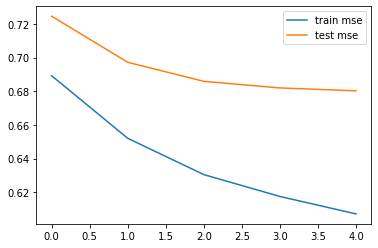

In [11]:
# train model
rbm.fit(data_train, mask_train, data_test, mask_test,
        epochs=5, batch_sz=256)

Significan't variational gap between training and testing performance, with further training model performance could improve by increasing the number of epochs.